# ⏳ Time Series Forecasting for OJ Sales

This project aims to build and evaluate a time series forecasting model to predict future sales for **3** different food products. By leveraging historical sales data, we apply machine learning and statistical modeling techniques to generate accurate forecasts that can support inventory planning, supply chain optimization, and data-driven business decisions.

---

### 🔍 Project Objectives:
- Load and explore Minute Maid sales time series data.
- Perform preprocessing (handling missing values, trend/seasonality decomposition).
- Build and compare forecasting models (XGBRegressor, Prophet, ElasticNet, etc.).
- Evaluate forecast accuracy using metrics like RMSE and MAPE.
- Visualize predictions and generate actionable insights.


# 1. Import Libraries

In [1]:
# Data import
from azureml.opendatasets import OjSalesSimulated

# os tools
import os
import glob
import pandas as pd
import numpy as np
from datetime import timedelta   

# metric & component libraries
from sklearn.metrics import mean_absolute_error, median_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# time series models
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from statsforecast.models import AutoARIMA, SeasonalNaive, Naive
from statsforecast import StatsForecast
import xgboost as xgb

# plotting the metrcis graph lib
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

C:\Users\preda\.conda\envs\azuredp100\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\preda\.conda\envs\azuredp100\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Download Datasets from azureml 

In [2]:
# String for folder name for data
ojsales_data_path = "ojsalesdata"
models_output_path = "models" # Define a path for saving models

# Create the data folder if it doesn't exist
if not os.path.exists(ojsales_data_path):
    os.mkdir(ojsales_data_path)
    print(f"Created data directory: {ojsales_data_path}")
else:
    print(f"Data directory already exists: {ojsales_data_path}")

# Create the models folder if it doesn't exist
if not os.path.exists(models_output_path):
    os.mkdir(models_output_path)
    print(f"Created models directory: {models_output_path}")
else:
    print(f"Models directory already exists: {models_output_path}")


Data directory already exists: ojsalesdata
Models directory already exists: models


In [3]:
# Initialize OJsales data obj
ojdata_obj = OjSalesSimulated()

# Pulling the files in the oj simulated opendatasets from azureml
ojsales_datafiles = ojdata_obj.get_file_dataset()

# Download the data into this specific folder,
# also incase it already exists still write on top of that file
print(f"Downloading data to {ojsales_data_path}...")
ojsales_datafiles.download(ojsales_data_path, overwrite=True)
print("Data download complete.")


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
Data download complete.


# 3. Extract Data 

In [4]:
# We'll use glob to find the actual CSV files, searching recursively.
print(f"Searching for CSV files in {ojsales_data_path}...")
csv_files = glob.glob(os.path.join(ojsales_data_path, "**", "*.csv"), recursive=True)

if not csv_files:
    print(f"Error: No CSV files found in '{ojsales_data_path}' or its subdirectories. Please check the download process and path.")
    exit() # Exit if no data files are found


Searching for CSV files in ojsalesdata...


In [5]:
# # real path for local pc data location
# real_local_support_path = r"F:\SkillUp TechMaster 2024-25\TechMaster DP-100\DP100-project\ojsalesdata\https%3A\%2Fazureopendatastorage.azurefd.net\ojsales-simulatedcontainer\oj_sales_data"

# Create an empty list to hold individual DataFrames
all_dfs = []

# Iterate through each CSV file
for file_path in csv_files:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    # Append the DataFrame to the list
    all_dfs.append(df)
print(f"Found and loaded {len(csv_files)} CSV files.")



Found and loaded 11973 CSV files.


# 4. Getting the Data Ready

In [40]:
# Concatenate all DataFrames in the list into a single DataFrame
# This will stack them vertically, creating the desired long format
combined_df = pd.concat(all_dfs, ignore_index=True)
print("All CSV files combined into a single DataFrame.")

# Ensure 'WeekStarting' is a datetime object for time series operations
combined_df['WeekStarting'] = pd.to_datetime(combined_df['WeekStarting'])
print("Converted 'WeekStarting' to datetime objects.")

# --- Start of Modified 'Quantity' Column Cleaning ---
# Ensure 'Quantity' is numeric and handle non-numeric values
print("Converting 'Quantity' column to numeric and handling non-numeric values...")

# Convert to numeric, coercing any errors to NaN
combined_df['Quantity'] = pd.to_numeric(combined_df['Quantity'], errors='coerce')

# Fill any NaN values (including those from coercion) with 0
combined_df['Quantity'] = combined_df['Quantity'].fillna(0)

# Ensure the column has a float data type for consistency, as StatsForecast expects numeric values
combined_df['Quantity'] = combined_df['Quantity'].astype(np.float32)
print("'Quantity' column successfully processed to numeric (float32) with NaNs filled.")
# --- End of Modified 'Quantity' Column Cleaning ---


All CSV files combined into a single DataFrame.
Converted 'WeekStarting' to datetime objects.
Converting 'Quantity' column to numeric and handling non-numeric values...
'Quantity' column successfully processed to numeric (float32) with NaNs filled.


In [41]:
# Display the first few rows and the info to verify the structure
print("Combined DataFrame Head:")
print(combined_df.head())
print("\nCombined DataFrame Info:")
combined_df.info()

Combined DataFrame Head:
  WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue
0   1990-06-14   1000  dominicks   12003.0       1   2.59  31087.77
1   1990-06-21   1000  dominicks   10239.0       1   2.39  24471.21
2   1990-06-28   1000  dominicks   17917.0       1   2.48  44434.16
3   1990-07-05   1000  dominicks   14218.0       1   2.33  33127.94
4   1990-07-12   1000  dominicks   15925.0       1   2.01  32009.25

Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  float32       
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue 

In [42]:
# unique Brands out there
combined_df["Brand"].unique()

array(['dominicks', 'minute.maid', 'tropicana'], dtype=object)

In [9]:
# how many rows are there for a certain store numbers
combined_df[combined_df["Store"]==138]

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
141570,1990-06-14,138,dominicks,15719,1,2.03,31909.57
141571,1990-06-21,138,dominicks,9882,1,2.58,25495.56
141572,1990-06-28,138,dominicks,18214,1,2.47,44988.58
141573,1990-07-05,138,dominicks,13987,1,2.37,33149.19
141574,1990-07-12,138,dominicks,15735,1,2.68,42169.80
...,...,...,...,...,...,...,...
141928,1992-09-03,138,tropicana,12864,1,2.53,32545.92
141929,1992-09-10,138,tropicana,17391,1,2.22,38608.02
141930,1992-09-17,138,tropicana,19427,1,2.43,47207.61
141931,1992-09-24,138,tropicana,12305,1,2.03,24979.15


In [10]:
# hoe omany rows are there for a different store number
combined_df[combined_df["Store"]==1000]

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
0,1990-06-14,1000,dominicks,12003,1,2.59,31087.77
1,1990-06-21,1000,dominicks,10239,1,2.39,24471.21
2,1990-06-28,1000,dominicks,17917,1,2.48,44434.16
3,1990-07-05,1000,dominicks,14218,1,2.33,33127.94
4,1990-07-12,1000,dominicks,15925,1,2.01,32009.25
...,...,...,...,...,...,...,...
358,1992-09-03,1000,tropicana,15013,1,2.62,39334.06
359,1992-09-10,1000,tropicana,16557,1,1.91,31623.87
360,1992-09-17,1000,tropicana,18281,1,2.33,42594.73
361,1992-09-24,1000,tropicana,15442,1,2.65,40921.30


In [11]:
# the number of stores that are available in the data
len(combined_df["Store"].unique())

3991

In [43]:

# Orderby the store numbers by the weekstarting column and also re-indexing the entire df
combined_df = combined_df.sort_values(by=["Store","WeekStarting"], ascending=True).reset_index(drop=True)
print("\nDataFrame sorted by Store and WeekStarting, and re-indexed.")

# first head
combined_df.head(5)


DataFrame sorted by Store and WeekStarting, and re-indexed.


,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
0,1990-06-14,138,dominicks,15719.0,1,2.03,31909.57
1,1990-06-14,138,minute.maid,10034.0,1,1.95,19566.30
2,1990-06-14,138,tropicana,19455.0,1,2.54,49415.70
3,1990-06-21,138,dominicks,9882.0,1,2.58,25495.56
4,1990-06-21,138,minute.maid,18154.0,1,1.96,35581.84


In [13]:
# information for the df
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  int64         
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue       1448733 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 77.4+ MB


## 4.1 Time Series Plots Interval Valuation

In [44]:
# --- 1. Select a Single Time Series for Plotting ---
# Let's pick an arbitrary Store and Brand for demonstration
# You might want to choose one that has a full history without missing values
sample_store = combined_df['Store'].iloc[0] # Gets the first store ID
sample_brand = combined_df['Brand'].iloc[0] # Gets the first brand name


In [45]:
# Filter the DataFrame for this specific series
single_series_df = combined_df[(combined_df['Store'] == sample_store) &
                                 (combined_df['Brand'] == sample_brand)].copy()

# Set 'WeekStarting' as the index for time series plotting functions
single_series_df = single_series_df.set_index('WeekStarting')

# Extract the 'Quantity' (or 'Revenue') column for analysis
time_series_data = single_series_df['Quantity']

# Handle any remaining NaNs in this specific series if present (e.g., from very early lags)
# For ACF/PACF, it's best to have no NaNs.
time_series_data = time_series_data.dropna()


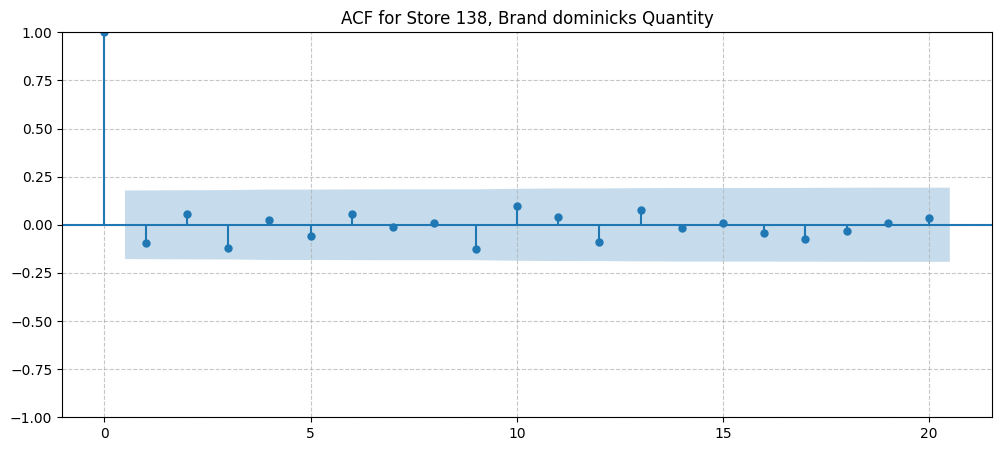

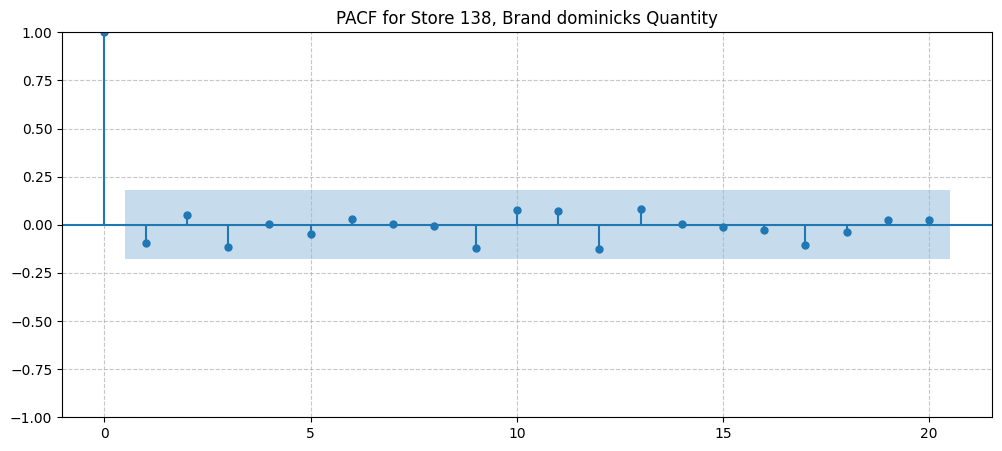

In [46]:

# plotting the 2 plots
if time_series_data.empty:
    print(f"No data available for Store {sample_store}, Brand {sample_brand} after filtering and dropping NaNs. Please try a different combination.")
else:
    # --- 2. Plot ACF (Autocorrelation Function) ---
    plt.figure(figsize=(12, 5))
    plot_acf(time_series_data, lags=20, ax=plt.gca(), title=f'ACF for Store {sample_store}, Brand {sample_brand} Quantity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- 3. Plot PACF (Partial Autocorrelation Function) ---
    plt.figure(figsize=(12, 5))
    plot_pacf(time_series_data, lags=20, ax=plt.gca(), title=f'PACF for Store {sample_store}, Brand {sample_brand} Quantity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## 4.2 Feature Engineering

In [47]:
# --- Feature Engineering ---
# 1. Time-based features from 'WeekStarting'
print("\n--- Creating Time-based Features ---")
combined_df['DayOfWeek'] = combined_df['WeekStarting'].dt.dayofweek
combined_df['Month'] = combined_df['WeekStarting'].dt.month
combined_df['WeekOfYear'] = combined_df['WeekStarting'].dt.isocalendar().week.astype(int)
combined_df['Year'] = combined_df['WeekStarting'].dt.year
combined_df['DayOfMonth'] = combined_df['WeekStarting'].dt.day
combined_df['IsMonthStart'] = combined_df['WeekStarting'].dt.is_month_start.astype(int)
combined_df['IsMonthEnd'] = combined_df['WeekStarting'].dt.is_month_end.astype(int)
print("Time-based features created.")




--- Creating Time-based Features ---
Time-based features created.


In [48]:
combined_df.head(5)

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue,DayOfWeek,Month,WeekOfYear,Year,DayOfMonth,IsMonthStart,IsMonthEnd
0,1990-06-14,138,dominicks,15719.0,1,2.03,31909.57,3,6,24,1990,14,0,0
1,1990-06-14,138,minute.maid,10034.0,1,1.95,19566.30,3,6,24,1990,14,0,0
2,1990-06-14,138,tropicana,19455.0,1,2.54,49415.70,3,6,24,1990,14,0,0
3,1990-06-21,138,dominicks,9882.0,1,2.58,25495.56,3,6,25,1990,21,0,0
4,1990-06-21,138,minute.maid,18154.0,1,1.96,35581.84,3,6,25,1990,21,0,0


In [19]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  int64         
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue       1448733 non-null  float64       
 7   DayOfWeek     1448733 non-null  int64         
 8   Month         1448733 non-null  int64         
 9   WeekOfYear    1448733 non-null  int32         
 10  Year          1448733 non-null  int64         
 11  DayOfMonth    1448733 non-null  int64         
 12  IsMonthStart  1448733 non-null  int32         
 13  IsMonthEnd    1448733 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(

In [49]:
# --- 2. Create Lag Features ---
# Lag features are past values of a variable. They are crucial for time series forecasting
# because the past often influences the future.

# We will create lags for 'Quantity', 'Price', and 'Advertising'.
# The chosen lags are 1 (previous week), 2 (two weeks ago), and 4 (four weeks ago/approx. last month).
# Why 1, 2, and 4?
# - Lag 1 & 2: Capture immediate trends and short-term memory.
# - Lag 4: Captures a "monthly" cycle, assuming your data is weekly. (4 weeks = ~1 month)

# We need to calculate lags SEPARATELY for each unique Store and Brand combination.
# Otherwise, you'd get the sales of a different store/brand as a lag, which is wrong.
# `groupby(['Store', 'Brand'])` makes sure the lag calculation stays within each group.
# `.shift(n)` moves the data down by 'n' rows, so the current row gets the value from 'n' rows above it.

lag_periods = [1, 2, 4] # The number of weeks to look back
columns_to_lag = ['Quantity', 'Price', 'Advert'] # Columns for which we want lags

print("\n--- Creating Lag Features ---")
for col in columns_to_lag:
    for lag in lag_periods:
        new_col_name = f'{col}_Lag_{lag}W' # e.g., 'Quantity_Lag_1W'
        # Group by Store and Brand to ensure lags are calculated within each series
        combined_df[new_col_name] = combined_df.groupby(['Store', 'Brand'])[col].shift(lag)
        print(f"Created: {new_col_name}")

print("\n--- DataFrame with new Lag Features (First few rows for one group) ---")
# Display head for a single store-brand combination to see lags clearly
print(combined_df[(combined_df['Store'] == sample_store) &
                   (combined_df['Brand'] == sample_brand)].head(7))




--- Creating Lag Features ---
Created: Quantity_Lag_1W
Created: Quantity_Lag_2W
Created: Quantity_Lag_4W
Created: Price_Lag_1W
Created: Price_Lag_2W
Created: Price_Lag_4W
Created: Advert_Lag_1W
Created: Advert_Lag_2W
Created: Advert_Lag_4W

--- DataFrame with new Lag Features (First few rows for one group) ---
   WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue  \
0    1990-06-14    138  dominicks   15719.0       1   2.03  31909.57   
3    1990-06-21    138  dominicks    9882.0       1   2.58  25495.56   
6    1990-06-28    138  dominicks   18214.0       1   2.47  44988.58   
9    1990-07-05    138  dominicks   13987.0       1   2.37  33149.19   
12   1990-07-12    138  dominicks   15735.0       1   2.68  42169.80   
15   1990-07-19    138  dominicks   11980.0       1   2.21  26475.80   
18   1990-07-26    138  dominicks   17059.0       1   2.21  37700.39   

    DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0           3      6          24  ...   

In [21]:
combined_df.head(5)

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue,DayOfWeek,Month,WeekOfYear,...,IsMonthEnd,Quantity_Lag_1W,Quantity_Lag_2W,Quantity_Lag_4W,Price_Lag_1W,Price_Lag_2W,Price_Lag_4W,Advert_Lag_1W,Advert_Lag_2W,Advert_Lag_4W
0,1990-06-14,138,dominicks,15719,1,2.03,31909.57,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-06-14,138,minute.maid,10034,1,1.95,19566.30,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-06-14,138,tropicana,19455,1,2.54,49415.70,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-06-21,138,dominicks,9882,1,2.58,25495.56,3,6,25,...,0,15719.0,NaN,NaN,2.03,NaN,NaN,1.0,NaN,NaN
4,1990-06-21,138,minute.maid,18154,1,1.96,35581.84,3,6,25,...,0,10034.0,NaN,NaN,1.95,NaN,NaN,1.0,NaN,NaN


In [50]:
print("DataFrame after Feature Engineering (head with new columns):")
print(combined_df.head())
print("\nCheck for NaNs created by lags:")
print(combined_df.isnull().sum())

DataFrame after Feature Engineering (head with new columns):
  WeekStarting  Store        Brand  Quantity  Advert  Price   Revenue  \
0   1990-06-14    138    dominicks   15719.0       1   2.03  31909.57   
1   1990-06-14    138  minute.maid   10034.0       1   1.95  19566.30   
2   1990-06-14    138    tropicana   19455.0       1   2.54  49415.70   
3   1990-06-21    138    dominicks    9882.0       1   2.58  25495.56   
4   1990-06-21    138  minute.maid   18154.0       1   1.96  35581.84   

   DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0          3      6          24  ...           0              NaN   
1          3      6          24  ...           0              NaN   
2          3      6          24  ...           0              NaN   
3          3      6          25  ...           0          15719.0   
4          3      6          25  ...           0          10034.0   

   Quantity_Lag_2W  Quantity_Lag_4W  Price_Lag_1W  Price_Lag_2W  Price_Lag_4W  \
0   

In [51]:
# --- 3. Handle Missing Values (NaNs) created by Lag Features ---
# The first few rows for each Store-Brand group will have NaNs for the lag features
# because there's no data from "the past" to look back at.
# For example, for 'Quantity_Lag_4W', the first 4 rows of each series will be NaN.

# We will fill these NaNs with 0. This implies "zero activity/value" for the missing past data.
# Get all the newly created lag feature column names
# Get all the newly created lag feature column names
lag_features_to_fill = [col for col in combined_df.columns if '_Lag_' in col]

# Fill NaNs in ONLY these specific lag features with 0
# NaNs in lag features typically occur at the beginning of each time series
# where previous values do not exist.
combined_df[lag_features_to_fill] = combined_df[lag_features_to_fill].fillna(0)

print("\n--- Check for NaNs after filling Lag Features with 0 ---")
# This should show 0 NaNs for all lag columns
print(f"Total NaNs in lag features after filling: {combined_df[lag_features_to_fill].isnull().sum().sum()}")
print("All lag feature NaNs filled with 0.")

print("\n--- DataFrame after filling NaNs (First few rows for one group) ---")
print(combined_df[(combined_df['Store'] == sample_store) &
                   (combined_df['Brand'] == sample_brand)].head(7))





--- Check for NaNs after filling Lag Features with 0 ---
Total NaNs in lag features after filling: 0
All lag feature NaNs filled with 0.

--- DataFrame after filling NaNs (First few rows for one group) ---
   WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue  \
0    1990-06-14    138  dominicks   15719.0       1   2.03  31909.57   
3    1990-06-21    138  dominicks    9882.0       1   2.58  25495.56   
6    1990-06-28    138  dominicks   18214.0       1   2.47  44988.58   
9    1990-07-05    138  dominicks   13987.0       1   2.37  33149.19   
12   1990-07-12    138  dominicks   15735.0       1   2.68  42169.80   
15   1990-07-19    138  dominicks   11980.0       1   2.21  26475.80   
18   1990-07-26    138  dominicks   17059.0       1   2.21  37700.39   

    DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0           3      6          24  ...           0              0.0   
3           3      6          25  ...           0          15719.0   
6     

# 5. Data Partition

In [52]:
# Our target variable is 'Quantity', which we want to predict.
target_column = 'Quantity'

# Define all the columns our model will use as input (features).
# We exclude 'WeekStarting' itself as we've extracted its components, and the 'Quantity' (target).
# All other columns (Price, Advert, Store, Brand, and all the new _Lag_ and time-based features)
# will be used as features.
features = [col for col in combined_df.columns if col not in ['WeekStarting', target_column]]

# Identify features that are categorical (represent distinct categories, not continuous numbers).
# These need special handling by some models (like one-hot encoding for linear models)
# or can be directly used as categories by others (like XGBoost).
categorical_features = [
    'Store', 'Brand', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek',
    'DayOfMonth', 'IsMonthStart', 'IsMonthEnd'
]

# Ensure that only columns actually present in our 'features' list are marked as categorical.
categorical_features = [f for f in categorical_features if f in features]

print("\n--- Final List of Features (X) ---")
print(features)
print("\n--- Categorical Features identified ---")
print(categorical_features)



--- Final List of Features (X) ---
['Store', 'Brand', 'Advert', 'Price', 'Revenue', 'DayOfWeek', 'Month', 'WeekOfYear', 'Year', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd', 'Quantity_Lag_1W', 'Quantity_Lag_2W', 'Quantity_Lag_4W', 'Price_Lag_1W', 'Price_Lag_2W', 'Price_Lag_4W', 'Advert_Lag_1W', 'Advert_Lag_2W', 'Advert_Lag_4W']

--- Categorical Features identified ---
['Store', 'Brand', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd']


In [53]:
# For time series forecasting, it's crucial to split data chronologically.
# We train our models on older data and test them on newer, unseen data,
# simulating a real-world forecasting scenario.
# Find the latest date in your entire dataset.
max_date = combined_df['WeekStarting'].max()

# Determine the cutoff point for the training data.
# Here, we're setting aside the last 18 weeks of data for testing.
test_weeks = 18 # You can change this number (e.g., 8, 20, etc.)
cutoff_date = max_date - timedelta(weeks=test_weeks)

# Create the training and testing DataFrames based on this cutoff date.
train_df = combined_df[combined_df['WeekStarting'] <= cutoff_date].copy()
test_df = combined_df[combined_df['WeekStarting'] > cutoff_date].copy()

# Separate features (X) and target (y) for both training and testing sets.
X_train = train_df[features]
y_train = train_df[target_column]

X_test = test_df[features]
y_test = test_df[target_column]


In [54]:
# Convert categorical columns in X_train and X_test to 'category' dtype.
# This helps tree-based models like XGBoost/LightGBM use these features efficiently.
# For linear models like ElasticNet, these will be One-Hot Encoded later.
for col in categorical_features:
    if col in X_train.columns: # Check if column exists before conversion
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns: # Check if column exists before conversion
        X_test[col] = X_test[col].astype('category')

print(f"\n--- Data Split Details ---")
print(f"Training data covers dates up to: {cutoff_date.date()}")
print(f"Test data covers dates from: {(cutoff_date + timedelta(weeks=1)).date()} to {max_date.date()}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde


--- Data Split Details ---
Training data covers dates up to: 1992-05-28
Test data covers dates from: 1992-06-04 to 1992-10-01
X_train shape: (1233219, 21), y_train shape: (1233219,)
X_test shape: (215514, 21), y_test shape: (215514,)


C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_26548\1184486323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# 6. Data Normalization

* The necessity of normalization depends on the type of machine learning model you use:

*  For **Tree-based Models** (like XGBRegressor):
*   Normalization is **NOT necessary**. Tree-based models work by making decisions based on thresholds (e.g., "Is Price > 1.5?"). The absolute scale of the numbers doesn't affect these decisions, only their relative order.

* - For **Linear Models** (like ElasticNet):
*   Normalization is **HIGHLY recommended and often NECESSARY**. Linear models (and other models sensitive to feature scales, like SVMs or K-Nearest Neighbors) are affected by the magnitude of feature values. If one feature has values from 0-1000 and another from 0-1, the larger-scaled feature will dominate the distance calculations or coefficient values, leading to suboptimal performance or convergence issues. `MinMaxScaler` rescales features to a specific range (e.g., 0 to 1).

* - For **Statistical Time Series Models** (like Naive, SeasonalNaive, AutoARIMA from StatsForecast):
*   These models typically work directly with the time series values themselves and their underlying statistical properties (mean, variance, correlations). They **do not usually require or benefit from feature scaling** in the same way ML models do. They primarily operate on the target variable's series.

#### CONCLUSION for YOUR Models:
* - You **do NOT need** to scale features for Naive, SeasonalNaive, AutoARIMA, or XGBRegressor.
* - You **WILL need** to scale features (and one-hot encode categorical features) specifically for **ElasticNet**.


In [27]:
print("\n--- Normalization Strategy ---")
print("MinMaxScaler (and OneHotEncoder for categories) will be prepared for the ElasticNet model.")
print("For Naive, SeasonalNaive, AutoARIMA, and XGBRegressor, scaling is generally not required.")



--- Normalization Strategy ---
MinMaxScaler (and OneHotEncoder for categories) will be prepared for the ElasticNet model.
For Naive, SeasonalNaive, AutoARIMA, and XGBRegressor, scaling is generally not required.


In [55]:

# To prepare for ElasticNet, we'll create a preprocessor:
# This preprocessor will:
# 1. Apply MinMaxScaler to all numerical features.
# 2. Apply OneHotEncoder to all categorical features.
# This ensures all features are on a comparable scale and in a suitable format for linear models.
# First, separate numerical and categorical feature names that are actually in X_train/X_test
numerical_cols_for_scaling = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols_for_encoding = [col for col in categorical_features if col in X_train.columns]

preprocessor_for_elasticnet = ColumnTransformer(
    transformers=[
        # Apply MinMaxScaler to numerical columns
        ('num_scaler', MinMaxScaler(), numerical_cols_for_scaling),
        # Apply OneHotEncoder to categorical columns (ignore unseen categories in test set)
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols_for_encoding)
    ],
    remainder='passthrough' # Keep any other columns that are not transformed (should be none here)
)

print(f"Features targeted for MinMaxScaler: \n{numerical_cols_for_scaling}")
print(f"Features targeted for OneHotEncoder: \n{categorical_cols_for_encoding}")
print("\n'preprocessor_for_elasticnet' is now defined and ready to be used with the ElasticNet model.")
print("You would apply this preprocessor to X_train and X_test just before training ElasticNet.")


Features targeted for MinMaxScaler: 
['Advert', 'Price', 'Revenue', 'Quantity_Lag_1W', 'Quantity_Lag_2W', 'Quantity_Lag_4W', 'Price_Lag_1W', 'Price_Lag_2W', 'Price_Lag_4W', 'Advert_Lag_1W', 'Advert_Lag_2W', 'Advert_Lag_4W']
Features targeted for OneHotEncoder: 
['Store', 'Brand', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd']

'preprocessor_for_elasticnet' is now defined and ready to be used with the ElasticNet model.
You would apply this preprocessor to X_train and X_test just before training ElasticNet.


# 7. Model Initialization

### Elastic Net

In [56]:

elasticnet_model = Pipeline(steps=[
    # Step 1: 'preprocessor' applies scaling to numerical features and one-hot encoding to categorical features.
    ('preprocessor', preprocessor_for_elasticnet),
    # Step 2: 'regressor' is the actual ElasticNet model, which now receives properly prepared data.
    ('regressor', ElasticNet(random_state=33)) # random_state for reproducibility
])
print("Initialized: ElasticNet Model (within a Pipeline with preprocessor)")


Initialized: ElasticNet Model (within a Pipeline with preprocessor)


### XGBRegressor

In [57]:
xgboost_model = XGBRegressor(
    objective='reg:squarederror', # This tells XGBoost to optimize for squared errors (common for regression)
    n_estimators=1000,           # The maximum number of boosting rounds (trees) to build. More trees can mean better accuracy but also more time.
    learning_rate=0.05,          # Controls the step size at each boosting iteration. Smaller values mean slower learning but can lead to better models.
    eval_metric='mae',           # Mean Absolute Error, used for evaluation during training (e.g., for early stopping).
    n_jobs=-1,                   # Uses all available CPU cores to speed up training.
    random_state=9               # Ensures that if you run the code multiple times, you get the same results (for reproducibility).
)
print("Initialized: XGBoost Regressor")


Initialized: XGBoost Regressor


### AutoARIMA

In [58]:
auto_arima_model = AutoARIMA(season_length=52)
print("Initialized: AutoARIMA Model (season_length=52)")

Initialized: AutoARIMA Model (season_length=52)


### Seasonal Naive

In [59]:
seasonal_naive_model = SeasonalNaive(season_length=52)
print("Initialized: Seasonal Naive Model (season_length=52)")

Initialized: Seasonal Naive Model (season_length=52)


### Naive 

In [60]:
naive_model = Naive()
print("Initialized: Naive Model")
print("\n--- All models initialized and organized! ---")


Initialized: Naive Model

--- All models initialized and organized! ---


In [61]:

# We can store all our initialized models in a dictionary for easy access and iteration later.
models = {
    "Naive": naive_model,
    "SeasonalNaive": seasonal_naive_model,
    "AutoARIMA": auto_arima_model,
    "XGBRegressor": xgboost_model,
    "ElasticNet": elasticnet_model
}

print("\nModels dictionary created with the following models:")
print(list(models.keys()))


Models dictionary created with the following models:
['Naive', 'SeasonalNaive', 'AutoARIMA', 'XGBRegressor', 'ElasticNet']


In [35]:
# This object handles scaling numerical features and one-hot encoding categorical features,
# which is crucial for models like ElasticNet.

# print("--- Initializing Forecasting Models ---")

# --- 1. StatsForecast Models (Naive, SeasonalNaive, AutoARIMA) ---
# They are designed to work directly with time series data (your 'Quantity' values over time)
# and don't typically take external features (like your lag columns or date parts) in the same way
# that machine learning models (like XGBoost or ElasticNet) do during their main 'fit' step.
# When we train them later, we'll give them a specific time series format ('unique_id', 'ds', 'y').

# Naive Model:
# This is the simplest model. It just predicts that the next value will be the same as the last observed value.
# (e.g., if sales yesterday were 100, it predicts 100 for today).


# Seasonal Naive Model:
# This model predicts that the next value will be the same as the value from the *same season* in the previous period.
# For example, if your data is weekly and you expect yearly seasonality, a 'season_length' of 52 would mean
# it predicts this week's sales to be the same as sales from the same week last year.
# We'll use 52 for our weekly data, assuming a yearly pattern.

# AutoARIMA Model:
# This model automatically searches for the best parameters for an ARIMA (AutoRegressive Integrated Moving Average) model.
# ARIMA models are powerful statistical models for time series. 'Auto' means it tries to find the best fit itself.
# We also provide a 'season_length' if we expect seasonal patterns (like yearly patterns in weekly data).


# --- 2. XGBoost Regressor Model ---
# XGBoost is a highly effective machine learning model. It builds many "decision trees" sequentially
# and learns from the errors of previous trees.
# Key point: XGBoost (and other tree-based models) do NOT require feature scaling/normalization.

# --- 3. ElasticNet Model ---
# ElasticNet is a type of linear regression model. It combines two regularization techniques (Lasso and Ridge)
# to prevent overfitting and improve model stability.
# Key point: Linear models like ElasticNet are sensitive to the scale of your features.
# This means if 'Price' is 0-10 and 'Advertising_Lag_1W' is 0-10000, 'Advertising_Lag_1W' might unfairly dominate.
# Therefore, we MUST use our 'preprocessor_for_elasticnet' (defined in the previous code block)
# to scale numerical features and convert categorical features into numerical form (one-hot encoding)
# BEFORE feeding them to the ElasticNet regressor.
# We use a Scikit-learn Pipeline to chain these steps together seamlessly.



# 8. Model Training

### 8.1 ForeCasting Models

In [65]:

# Create the specific DataFrame needed by StatsForecast
train_sf_df = train_df[['Store', 'Brand', 'WeekStarting', 'Quantity']].copy()

# Combine Store and Brand into a single 'unique_id' for each distinct series
train_sf_df['unique_id'] = train_sf_df['Store'].astype(str) + '_' + train_sf_df['Brand'].astype(str)

# Rename columns to 'ds' and 'y' as StatsForecast expects
train_sf_df = train_sf_df.rename(columns={'WeekStarting': 'ds', 'Quantity': 'y'})

# Ensure 'ds' is datetime and 'unique_id' is string type as required
train_sf_df['ds'] = pd.to_datetime(train_sf_df['ds'])
train_sf_df['unique_id'] = train_sf_df['unique_id'].astype(str)

# --- NEW: Robust cleaning for 'y' column in train_sf_df immediately before StatsForecast fit ---
print("Applying final robust numeric conversion to 'train_sf_df['y']'...")
train_sf_df['y'] = pd.to_numeric(train_sf_df['y'], errors='coerce')
train_sf_df['y'] = train_sf_df['y'].fillna(0).astype(np.float32)
print("'train_sf_df['y']' column is now explicitly numeric (float32).")
# --- END NEW ---


Applying final robust numeric conversion to 'train_sf_df['y']'...
'train_sf_df['y']' column is now explicitly numeric (float32).


In [66]:
print("\nTraining Naive, SeasonalNaive, and AutoARIMA models...")
sf = StatsForecast(
    models=[models["Naive"], models["SeasonalNaive"], models["AutoARIMA"]],
    freq='W',    # Set the frequency of your data: 'W' for weekly. This is crucial for seasonal models.
    n_jobs=-1,   # Use all available CPU cores for faster training across multiple series.
    verbose=True # Set to True for more detailed output during fitting.
)


Training Naive, SeasonalNaive, and AutoARIMA models...


In [67]:

# Fit all the defined StatsForecast models to the prepared training data.
sf.fit(train_sf_df)
print("StatsForecast Models Training Complete!")


ValueError: could not convert string to float: 'dominicks'

In [ ]:

# --- Saving StatsForecast Models ---
# With StatsForecast, you typically save the 'StatsForecast' object itself.
# This object contains the fitted versions of all the models it managed.
joblib.dump(sf, '..\models\statsforecast_fitted_models.pkl')
print("Saved Naive, SeasonalNaive, AutoARIMA models as 'statsforecast_fitted_models.pkl'")


### 8.2 XGBRegressor

In [ ]:
# XGBoost is a powerful machine learning model that takes features (X) and target (y).
# It can directly handle Pandas categorical dtypes if specified.
print("\nTraining XGBoost Regressor...")
xgboost_model = models["XGBRegressor"] # Get the initialized model


In [ ]:
xgboost_model.fit(X_train, y_train,
                  # eval_set: Allows monitoring performance on the test set during training.
                  eval_set=[(X_test, y_test)],
                  eval_metric='mae', # Metric to show during evaluation (Mean Absolute Error).
                  # callbacks: Used for early stopping to prevent overfitting and save time.
                  # If performance on eval_set doesn't improve for 50 rounds, training stops.
                  callbacks=[xgb.callback.EarlyStopping(rounds=50, verbose=False)],
                 )
print("XGBoost Regressor Training Complete!")

In [ ]:
# --- Saving XGBoost Model ---
joblib.dump(xgboost_model, '..\models\xgboost_model.pkl')
print("Saved XGBoost Regressor as 'xgboost_model.pkl'")


### 8.3 ElasticNet

In [ ]:
print("\nTraining ElasticNet Model...")
elasticnet_model = models["ElasticNet"] # Get the initialized Pipeline

In [ ]:
elasticnet_model.fit(X_train, y_train)
print("ElasticNet Model Training Complete!")


In [ ]:
# Save the entire Pipeline, as it includes the preprocessor and the regressor.
joblib.dump(elasticnet_model, '..\models\elasticnet_model.pkl')
print("Saved ElasticNet Model (Pipeline) as 'elasticnet_model.pkl'")

print("\n--- All specified models trained and saved successfully! ---")

# 9. Model Metrics Final outputs